In [79]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [80]:
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda
from keras.models import Model
from keras.models import load_model
import tensorflow as tf
import os
import skimage

In [81]:
characters = '0123456789+-*/=()'
width, height, n_len, n_class = 400, 80, 14, len(characters) + 1

In [82]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [83]:
def evaluate(batch_size=128, steps=10):
    batch_acc = 0
    generator = gen(batch_size)
    for i in range(steps):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)[:, :n_len]
        if out.shape[1] == n_len:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / steps

In [84]:
from keras.callbacks import *

class Evaluator(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(steps=20)*100
        self.accs.append(acc)
        print('')
        print('acc: %f%%' % acc)

evaluator = Evaluator()

In [85]:
from keras.layers import *
from keras.models import *

rnn_size = 128

input_tensor = Input((width, height, 1))
x = input_tensor
for i in range(3):
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape().as_list()
rnn_length = conv_shape[1]
rnn_dimen = conv_shape[2]*conv_shape[3]
print(conv_shape, rnn_length, rnn_dimen)
x = Reshape(target_shape=(rnn_length, rnn_dimen))(x)
rnn_length -= 2

x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model.output, labels, input_length, label_length])

[None, 46, 6, 128] 46 768


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [8]:
model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

In [86]:
# model = load_model('crnn_model.h5', custom_objects={'tf': tf, '<lambda>': lambda y_true, y_pred: y_pred})
model = load_model('crnn_model_10.h5')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [178]:
def generate():
    ds = '0123456789'
    ts = ['{}{}{}{}{}', '({}{}{}){}{}', '{}{}({}{}{})']
    os = '+-*/'
    # os = ['+', '-', 'times', 'div']
    cs = [random.choice(ds) if x % 2 == 0 else random.choice(os) for x in range(5)]
    return random.choice(ts).format(*cs)

def get_img_by_char(char, base_path='./pre_ocr'):
    """
    get a img by giving char
    :param char:
    :param base_path:
    :return:
    """
    opdict = {'+': 10, '-': 11, '*': 12, '/': 13, '=': 14, '(': 15, ')': 16}
    if char in opdict.keys():
        char = opdict[char]
    path = os.path.join(base_path, str(char))
    files = os.listdir(path)

    rdm = random.randint(0, len(files) - 1)
    
    if rdm >= len(files):
        print(path, len(files), rdm)
        
    file = files[rdm]
    path = os.path.join(path, file)
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def get_sequence_img(chars):
    x = get_img_by_char(chars[0])
    for i in range(1, len(chars)):
        x = np.hstack([x, get_img_by_char(chars[i])])
    x = cv2.resize(x, (400, 80))
#     x = skimage.util.random_noise(x, mode='gaussian', clip=True)
    print('get_sequence_img output')
    plt.imshow(x)
    plt.show()
#     print (chars, x.shape)
    return x

def gen(batch_size=128, gene=4):
    X = np.zeros((batch_size, width, height, 1), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
#             random_str = '60/3=20'
            tmp = np.array(get_sequence_img(random_str))
            tmp = tmp.reshape(tmp.shape[0], tmp.shape[1], 1)
            tmp = tmp.transpose(1, 0, 2)
            
            X[i] = tmp
            y[i] = [characters.find(x) for x in random_str]
        
        i = 0
        XX = None
        yy = None
        for batch in datagen.flow(X, y, batch_size=batch_size):
#             print(batch[0].shape, batch[1].shape)
            
            if not type(XX) == np.ndarray:
                XX = batch[0]
                yy = batch[1]
            else:
                XX = np.concatenate([XX, batch[0]], axis=0)
                yy = np.concatenate([yy, batch[1]], axis=0)
            
            i += 1
            if i >= gene:
                break
        yield [XX, yy, np.ones(batch_size * gene) * rnn_length, np.ones(batch_size * gene) * n_len], np.ones(batch_size * gene)

get_sequence_img output


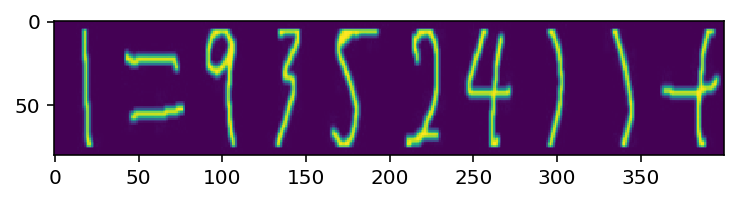

get_sequence_img output


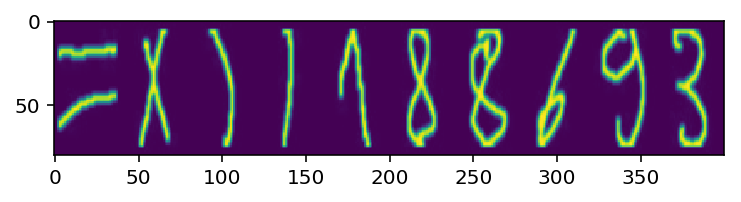

(8, 400, 80, 1)


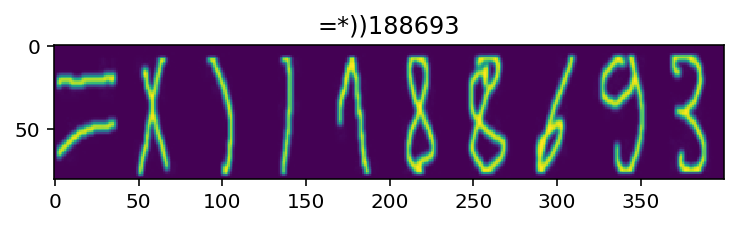

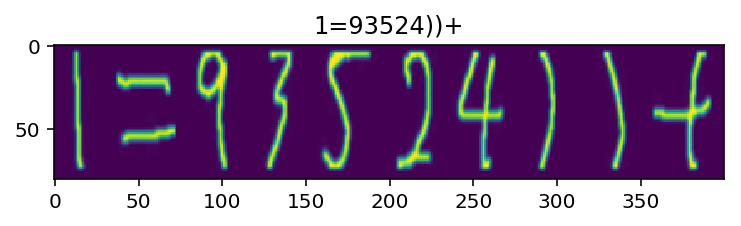

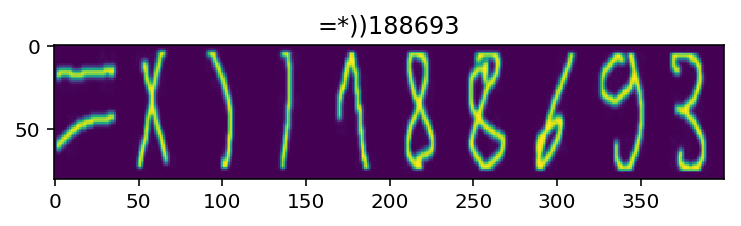

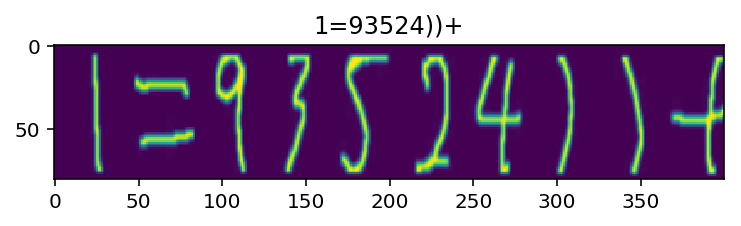

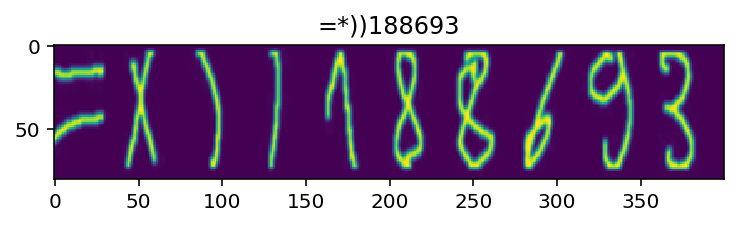

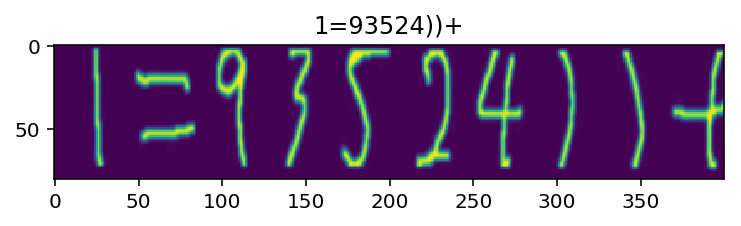

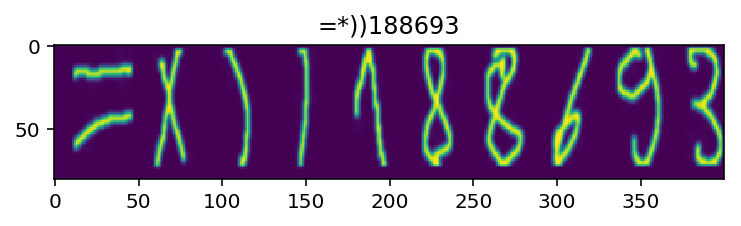

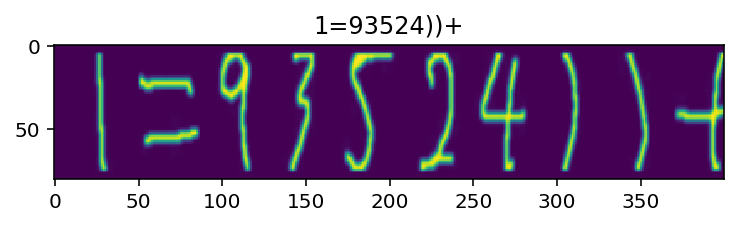

In [181]:
(X_vis, y_vis, input_length_vis, label_length_vis), _ = next(gen(2))
# print(X_vis.shape, y_vis, input_length_vis, label_length_vis)
print(X_vis.shape)

for i in range(X_vis.shape[0]):
    tmp = X_vis[i].transpose(1, 0, 2)
    tmp = tmp[:, :, 0]

    plt.imshow(tmp)
    plt.title(''.join([characters[i] for i in y_vis[i]]))
    plt.show()


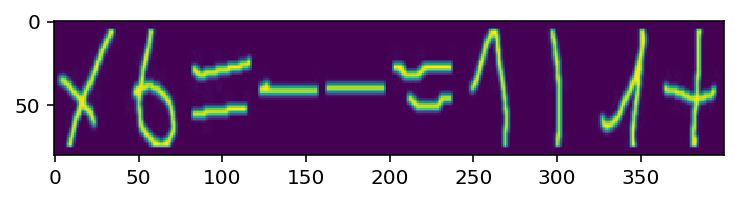

[[ 8  2  6  2 12  8 12  8 12  2  1  2 12  8]]


In [104]:
n_len = 10
generator = gen(1)
[X_test, y_test, _, _], _  = next(generator)
y_pred = model.predict(X_test)
# print y_pred[0]
shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(y_pred.shape[0])*rnn_length)[0][0]
out = K.get_value(ctc_decode)[:, :]
print(out)

origin size: (213, 1288)
resize: (80, 400)
result: [[13  2  8  2  8  2  8  0  6  8  2 12  6  8 12  6  8  2]]


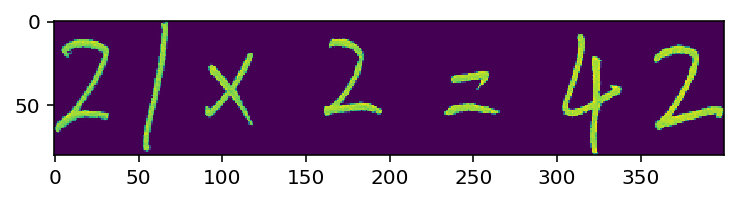

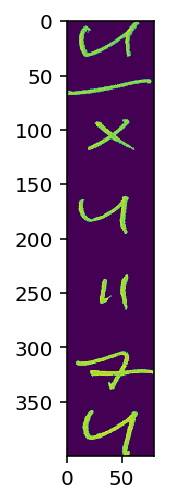

In [91]:
img = cv2.imread('imgs/1.jpg', cv2.IMREAD_GRAYSCALE)
print('origin size:', img.shape)

x = cv2.resize(img, (400, 80))
xt = x.transpose(1, 0)
xts = xt.reshape(1, 400, 80, 1)
print('resize:', x.shape)

y_pred = model.predict(xts)
# print y_pred[0]
shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(y_pred.shape[0]) * rnn_length)[0][0]
out = K.get_value(ctc_decode)[:, :]
print('result:', out)

plt.imshow(x)
plt.show()

plt.imshow(xts[0, :, :, 0])

origin size: (221, 1277)
resize: (80, 400)
result: [[ 8  2  8  2  8  2 12  3  0  8 12  8  2  8]]


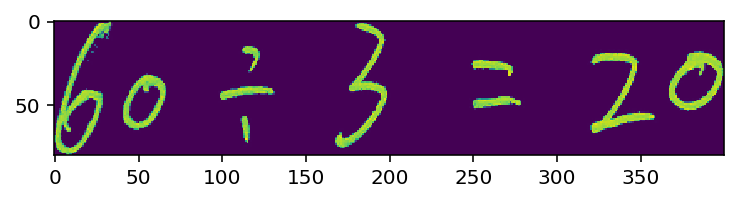

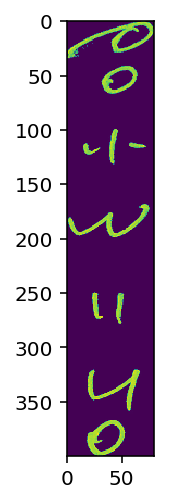

In [93]:
img = cv2.imread('imgs/2.jpg', cv2.IMREAD_GRAYSCALE)
print('origin size:', img.shape)

x = cv2.resize(img, (400, 80))
xt = x.transpose(1, 0)
xts = xt.reshape(1, 400, 80, 1)
print('resize:', x.shape)

y_pred = model.predict(xts)
# print y_pred[0]
shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(y_pred.shape[0]) * rnn_length)[0][0]
out = K.get_value(ctc_decode)[:, :]
print('result:', out)

plt.imshow(x)
plt.show()

plt.imshow(xts[0, :, :, 0])

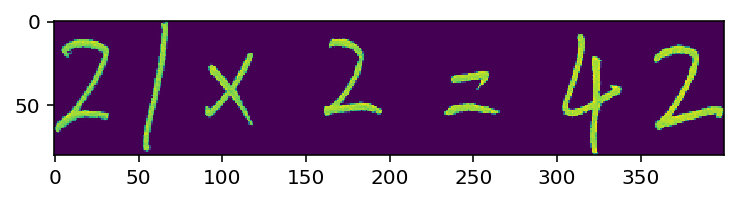

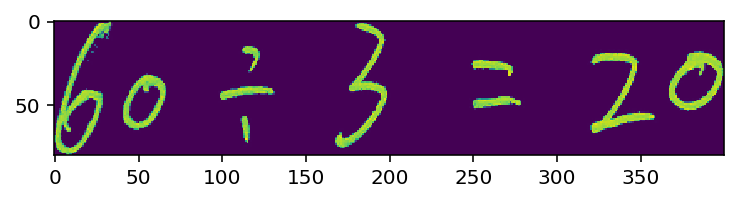

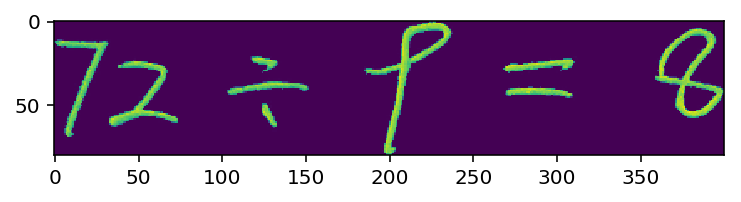

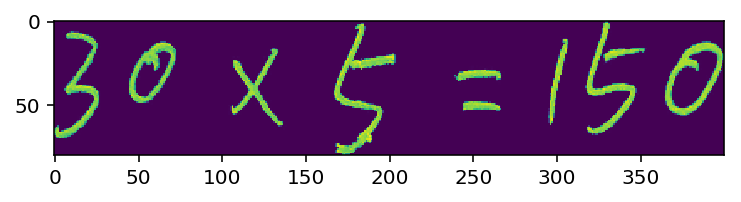

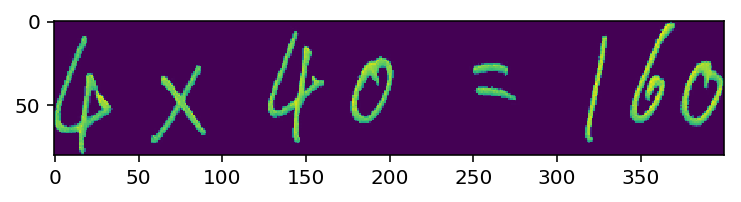

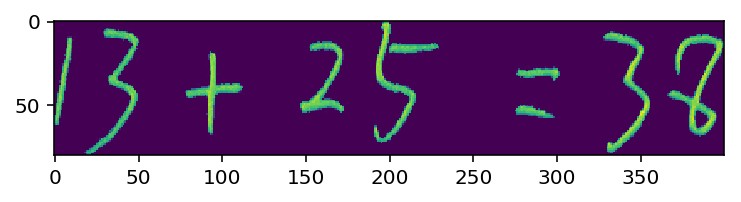

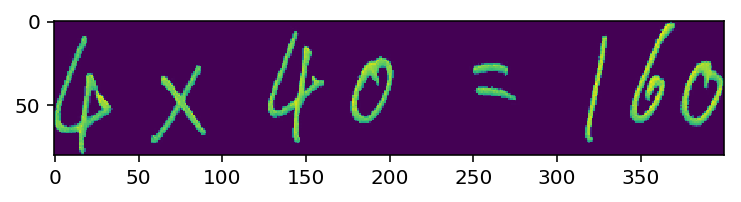

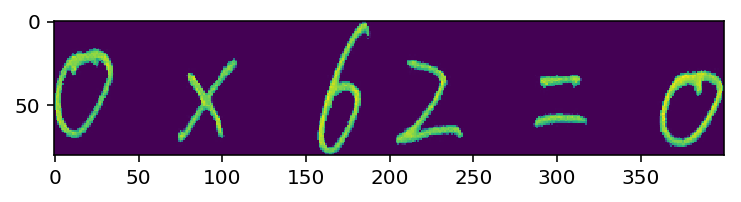

(8, 400, 80, 1)
[[13  2  8  2  8  2  8  0  6  8  2 12  6  8 12  6  8  2 -1 -1 -1 -1 -1]
 [ 8  2  8  2  8  2 12  3  0  8 12  8  2  8 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  8  6  8 12  2  8  8  0  0  8  0  9  0  3 12  8 12  9  8 -1 -1 -1]
 [12  8  0  2  0  8  0  8  2  8  2  8  2  8  2  8 -1 -1 -1 -1 -1 -1 -1]
 [ 8  2  8  2  8  8  2  8  2  8  3  8  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 8 12  8  2 12  8  2  8  2  8  2  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 8  2  8  2  8  8  2  8  2  8  3  8  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2 12  8  2  8  2  8  2  8  2  8  2  8  2 12  2  6  8  2 12  6 12  8]]


In [92]:
img = []
for i in range(1, 9):
    tmp = cv2.imread('imgs/%s.jpg' % i, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(tmp, (400, 80))
    plt.imshow(x)
    plt.show()
    xt = x.transpose(1, 0)
    xts = xt.reshape(400, 80, 1)
    li = xts.tolist()
#     print(len(li[0]))
    img.append(li)
img = np.array(img)

print(img.shape)

y_pred = model.predict(img)
# print y_pred[0]
shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(y_pred.shape[0]) * rnn_length)[0][0]
out = K.get_value(ctc_decode)[:, :]
print(out)

In [144]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    
datagen = ImageDataGenerator(
            rotation_range=0.4,
            width_shift_range=0.04,
            height_shift_range=0.04,
            shear_range=0.2,
            zoom_range=0.0,
            fill_mode='nearest')    

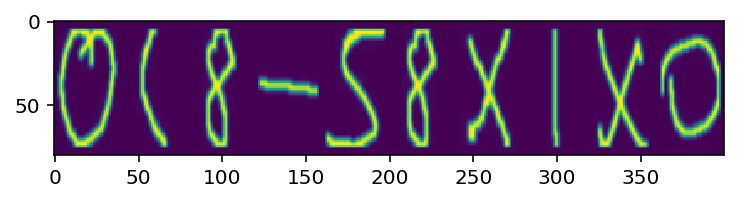

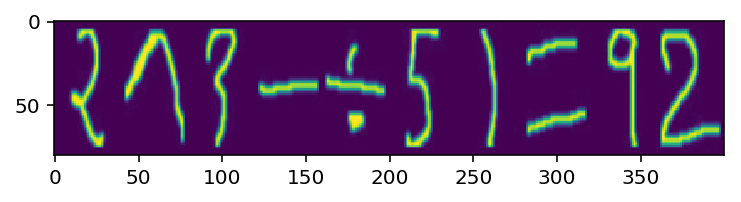

(2, 400, 80, 1) (2, 10)


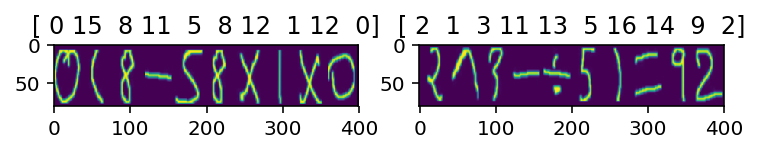

(2, 400, 80, 1) (2, 10)


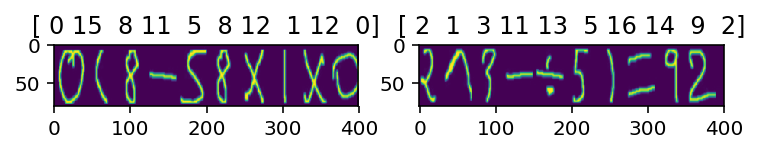

(2, 400, 80, 1) (2, 10)


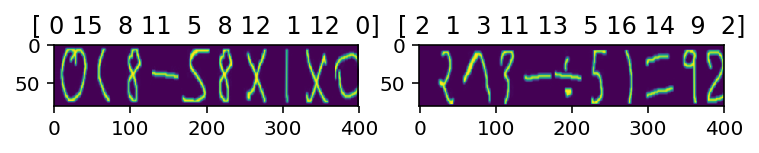

(2, 400, 80, 1) (2, 10)


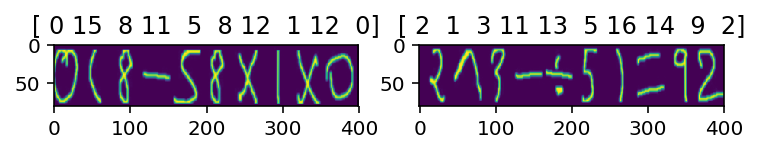

(2, 400, 80, 1) (2, 10)


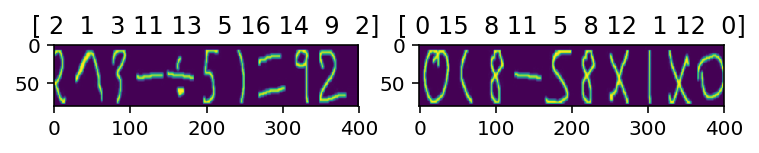

(2, 400, 80, 1) (2, 10)


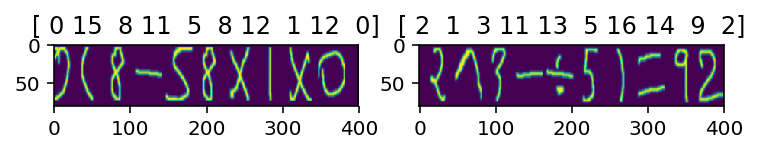

(2, 400, 80, 1) (2, 10)


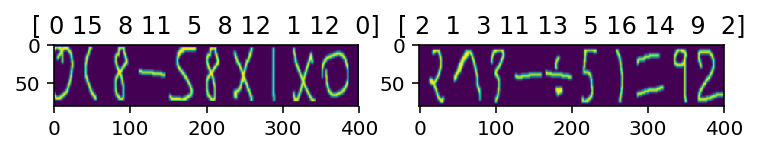

In [153]:
(X_vis, y_vis, input_length_vis, label_length_vis), _ = next(gen(2))
# print(X_vis.shape, y_vis, input_length_vis, label_length_vis)
# print(X_vis[0].shape)

i = 0
for batch in datagen.flow(X_vis, y_vis, batch_size=2):
    print(batch[0].shape, batch[1].shape)
    plt.subplot(1, 2, 1)
    plt.title(batch[1][0])
    plt.imshow(batch[0][0, :, :, 0].transpose(1, 0))
    plt.subplot(1, 2, 2)
    plt.title(batch[1][1])
    plt.imshow(batch[0][1, :, :, 0].transpose(1, 0))
    plt.show()
    i += 1
    if i > 6:
        break

In [111]:
!mkdir genimg